# Day 9
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian, reflection and rotation augmentation

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Options

In [2]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [3]:
class RotationReflectionBatch(BatchYielder):
    def __init__(self, header, datafile=None, augRotMult=4, trainTimeAug=True, testTimeAug=True):
        self.header = header
        self.augmented = True
        self.augRotMult = augRotMult
        self.augMult = self.augRotMult*4
        self.trainTimeAug = trainTimeAug
        self.testTimeAug = testTimeAug
        if not isinstance(datafile, types.NoneType):
            self.addSource(datafile)
    
    @staticmethod
    def rotate(inData, vectors):
        for vector in vectors:
            inData.loc[:, vector + '_px'] = inData.loc[:, vector + '_px']*np.cos(inData.loc[:, 'aug_angle'])-inData.loc[:, vector + '_py']*np.sin(inData.loc[:, 'aug_angle'])
            inData.loc[:, vector + '_py'] = inData.loc[:, vector + '_py']*np.cos(inData.loc[:, 'aug_angle'])+inData.loc[:, vector + '_px']*np.sin(inData.loc[:, 'aug_angle'])
    
    @staticmethod
    def reflect(inData, vectors):
        for vector in vectors:
            for coord in ['_px', '_pz']:
                try:
                    inData.loc[inData['aug' + coord] == 1, vector + coord] = -inData.loc[inData['aug' + coord] == 1, vector + coord]
                except KeyError:
                    pass
            
    def getBatch(self, index, datafile=None):
        if isinstance(datafile, types.NoneType):
            datafile = self.source
            
        index = str(index)
        weights = None
        targets = None
        if 'fold_' + index + '/weights' in datafile:
            weights = np.array(datafile['fold_' + index + '/weights'])
        if 'fold_' + index + '/targets' in datafile:
            targets = np.array(datafile['fold_' + index + '/targets'])

        inputs = pandas.DataFrame(np.array(datafile['fold_' + index + '/inputs']), columns=self.header)
        vectors = [x[:-3] for x in inputs.columns if '_px' in x]
        inputs['aug_angle'] = 2*np.pi*np.random.random(size=len(inputs))
        for coord in ['_px', '_pz']:
            inputs['aug' + coord] = np.random.randint(0, 2, size=len(inputs))
        self.rotate(inputs, vectors)
        self.reflect(inputs, vectors)
        
        return {'inputs':inputs[self.header].values,
                'targets':targets,
                'weights':weights}
    
    def getTestBatch(self, index, augIndex, datafile=None):
        if augIndex >= self.augMult:
            print "Invalid augmentation index passed", augIndex
            return -1
        
        if isinstance(datafile, types.NoneType):
            datafile = self.source
            
        index = str(index)
        weights = None
        targets = None
        if 'fold_' + index + '/weights' in datafile:
            weights = np.array(datafile['fold_' + index + '/weights'])
        if 'fold_' + index + '/targets' in datafile:
            targets = np.array(datafile['fold_' + index + '/targets'])
            
        inputs = pandas.DataFrame(np.array(datafile['fold_' + index + '/inputs']), columns=self.header)
        rotIndex = augIndex%self.augRotMult
        refIndex = '{0:02b}'.format(int(augIndex/4))
        vectors = [x[:-3] for x in inputs.columns if '_px' in x]
        inputs['aug_angle'] = np.linspace(0, 2*np.pi, (self.augRotMult)+1)[rotIndex]
        for i, coord in enumerate(['_px', '_pz']):
            inputs['aug' + coord] = int(refIndex[i])
        self.rotate(inputs, vectors)
        self.reflect(inputs, vectors)

        return {'inputs':inputs[self.header].values,
                'targets':targets,
                'weights':weights}

In [4]:
trainData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"))
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"))

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.229s 


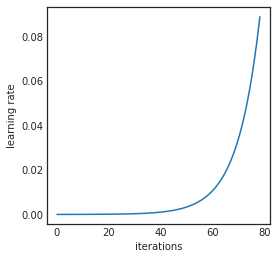

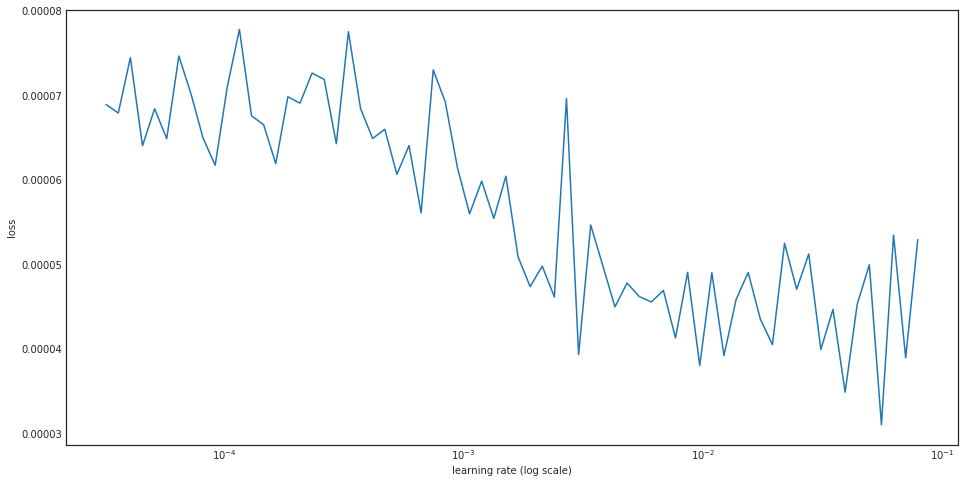

______________________________________



In [59]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,1e-1], trainOnWeights=True, verbose=0)

In [60]:
compileArgs['lr'] = 1e-3

## Train classifier

Using cosine annealing
Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 4.4283700067e-05
2 New best found: 3.92413603924e-05
3 New best found: 3.8136331588e-05
4 New best found: 3.76118607045e-05
5 New best found: 3.66991365834e-05
6 New best found: 3.65648081643e-05
7 New best found: 3.62912261731e-05
9 New best found: 3.59634010658e-05
10 New best found: 3.57225122846e-05
11 New best found: 3.55747691999e-05
12 New best found: 3.5280910456e-05
13 New best found: 3.50571040309e-05
19 New best found: 3.49350544745e-05
23 New best found: 3.46378303685e-05
25 New best found: 3.45670017287e-05
26 New best found: 3.45202360361e-05
27 New best found: 3.44955552434e-05
28 New best found: 3.44067859261e-05
30 New best found: 3.43423835319e-05
31 New best found: 3.41905804161e-05
42 New best found: 3.41592612905e-05
43 New best found: 3.41253441406e-05
45 New best found: 3.4043416199e-05
48 New best found: 3.39002235063e-05
49 New best found

4 New best found: 3.78249177507e-05
5 New best found: 3.72683023044e-05
6 New best found: 3.61688996482e-05
7 New best found: 3.60701958014e-05
10 New best found: 3.54168298926e-05
12 New best found: 3.53596147216e-05
13 New best found: 3.52182623241e-05
14 New best found: 3.50269911467e-05
15 New best found: 3.4985075895e-05
19 New best found: 3.49350209378e-05
22 New best found: 3.49247132213e-05
24 New best found: 3.45678715887e-05
25 New best found: 3.4486316528e-05
26 New best found: 3.43957479235e-05
28 New best found: 3.42847690958e-05
29 New best found: 3.41440662525e-05
43 New best found: 3.41228153932e-05
46 New best found: 3.40447811393e-05
50 New best found: 3.40317527623e-05
51 New best found: 3.38597993306e-05
52 New best found: 3.3853061916e-05
53 New best found: 3.36230488649e-05
62 New best found: 3.35380999737e-05
91 New best found: 3.35215961606e-05
97 New best found: 3.34244194977e-05
107 New best found: 3.33789106423e-05
109 New best found: 3.33284770153e-05
120 Ne

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129681). Check your callbacks.
  % delta_t_median)


1 New best found: 4.40606435463e-05
2 New best found: 3.84005385444e-05
3 New best found: 3.76965501518e-05
4 New best found: 3.70803621779e-05
5 New best found: 3.63651102074e-05
6 New best found: 3.60091066169e-05
7 New best found: 3.58653378862e-05
8 New best found: 3.58378071575e-05
10 New best found: 3.52014953287e-05
11 New best found: 3.51616657668e-05
12 New best found: 3.49883006841e-05
13 New best found: 3.47389339188e-05
14 New best found: 3.45910622362e-05
19 New best found: 3.43213896343e-05
21 New best found: 3.41892425033e-05
23 New best found: 3.40336757722e-05
24 New best found: 3.40070555647e-05
25 New best found: 3.3874703723e-05
27 New best found: 3.36580277821e-05
30 New best found: 3.36086892979e-05
46 New best found: 3.34169147632e-05
48 New best found: 3.31674940274e-05
52 New best found: 3.30520318361e-05
54 New best found: 3.29674618867e-05
59 New best found: 3.29342173864e-05
62 New best found: 3.28300252901e-05
82 New best found: 3.27918262594e-05
90 New bes

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128177). Check your callbacks.
  % delta_t_median)


1 New best found: 4.41168455071e-05
2 New best found: 3.91708477808e-05
3 New best found: 3.83888737936e-05
4 New best found: 3.64945554034e-05
5 New best found: 3.56431768672e-05
6 New best found: 3.51131555634e-05
8 New best found: 3.48386571807e-05
9 New best found: 3.47682959727e-05
10 New best found: 3.44097060954e-05
12 New best found: 3.39111699338e-05
13 New best found: 3.38612272346e-05
14 New best found: 3.38606114505e-05
20 New best found: 3.36100679068e-05
21 New best found: 3.33670443615e-05
22 New best found: 3.30803365303e-05
26 New best found: 3.30362210276e-05
27 New best found: 3.30175006004e-05
28 New best found: 3.30018611972e-05
29 New best found: 3.29403628951e-05
31 New best found: 3.27798041403e-05
38 New best found: 3.26895766765e-05
41 New best found: 3.25936160646e-05
47 New best found: 3.2497093512e-05
48 New best found: 3.24532141198e-05
49 New best found: 3.24524255485e-05
50 New best found: 3.23490997677e-05
51 New best found: 3.2338616847e-05
52 New best

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136126). Check your callbacks.
  % delta_t_median)


1 New best found: 4.43912757889e-05
2 New best found: 3.88398694861e-05
3 New best found: 3.79579128561e-05
4 New best found: 3.67962338987e-05
5 New best found: 3.60033894353e-05
6 New best found: 3.53088962593e-05
9 New best found: 3.51543479349e-05
10 New best found: 3.45748835007e-05
12 New best found: 3.43029961745e-05
13 New best found: 3.42112397691e-05
14 New best found: 3.41679679589e-05
19 New best found: 3.38437711344e-05
23 New best found: 3.38073869167e-05
24 New best found: 3.35271745171e-05
25 New best found: 3.33812462663e-05
26 New best found: 3.31937563009e-05
29 New best found: 3.3119485174e-05
40 New best found: 3.30871682153e-05
42 New best found: 3.30608952394e-05
43 New best found: 3.30269069989e-05
48 New best found: 3.28153097026e-05
51 New best found: 3.26616056531e-05
53 New best found: 3.26172652502e-05
55 New best found: 3.25306738952e-05
58 New best found: 3.23576839601e-05
89 New best found: 3.23347572812e-05
92 New best found: 3.22972809614e-05
94 New be

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171021). Check your callbacks.
  % delta_t_median)


1 New best found: 4.35155379774e-05
2 New best found: 3.81343497366e-05
3 New best found: 3.75404082714e-05
4 New best found: 3.72067745129e-05
5 New best found: 3.58766189231e-05
6 New best found: 3.5507864448e-05
7 New best found: 3.54384494403e-05
8 New best found: 3.54099132484e-05
9 New best found: 3.49525738738e-05
10 New best found: 3.48658861892e-05
11 New best found: 3.4535128999e-05
12 New best found: 3.41997834449e-05
13 New best found: 3.41163888823e-05
14 New best found: 3.40471682083e-05
19 New best found: 3.39979744687e-05
20 New best found: 3.38368670931e-05
21 New best found: 3.37008347279e-05
23 New best found: 3.36595070192e-05
24 New best found: 3.35965095694e-05
25 New best found: 3.34811838801e-05
27 New best found: 3.33689498549e-05
28 New best found: 3.32468298639e-05
30 New best found: 3.31919016038e-05
31 New best found: 3.31782364744e-05
42 New best found: 3.30964749138e-05
44 New best found: 3.30656929955e-05
46 New best found: 3.28010133084e-05
49 New best 

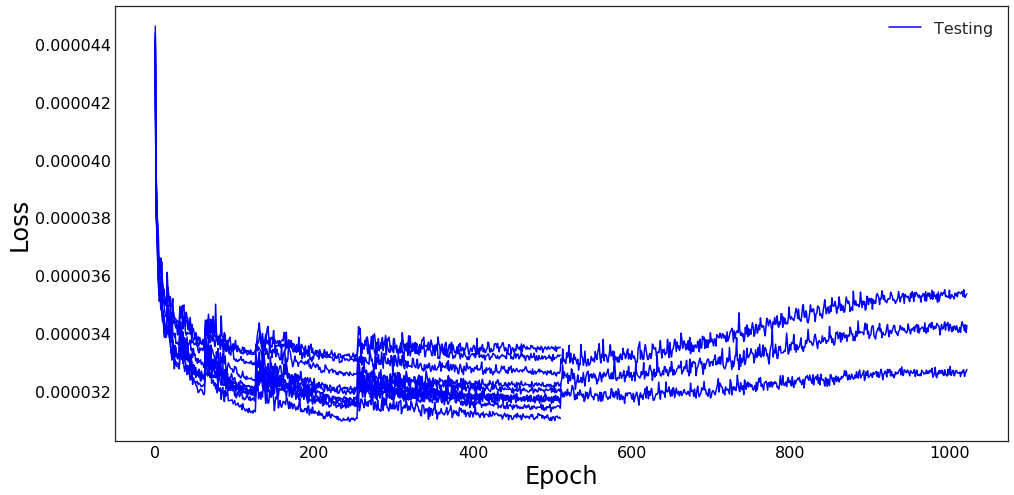

Mean wAUC = 0.0643 +- 0.0009
______________________________________



In [61]:
results, histories = batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams,
                                          patience=2, cosAnnealMult=2, trainOnWeights=True,
                                          maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [62]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [63]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

Choosing ensemble by loss
Model 0 is 1 with loss = 3.095676987339591e-05
Model 1 is 2 with loss = 3.1293976467134276e-05
Model 2 is 7 with loss = 3.1404798608397036e-05
Model 3 is 8 with loss = 3.154818800737811e-05
Model 4 is 9 with loss = 3.1633050731225454e-05
Model 5 is 6 with loss = 3.185695730582516e-05
Model 6 is 5 with loss = 3.1880775347951126e-05
Model 7 is 3 with loss = 3.253257214143923e-05
Model 8 is 4 with loss = 3.299015853107501e-05
Model 9 is 0 with loss = 3.313168092899132e-05


In [75]:
np.mean([3.095676987339591e-05,
3.1293976467134276e-05,
3.1404798608397036e-05,
3.154818800737811e-05,
3.1633050731225454e-05,
3.185695730582516e-05,
3.1880775347951126e-05,
3.253257214143923e-05,
3.299015853107501e-05,
3.313168092899132e-05])

3.1922892794281264e-05

## Response on development data

In [ ]:
def batchEnsemblePredict(ensemble, weights, data, predName='pred', nOut=1, outputPipe=None, ensembleSize=None, nFolds=-1, verbose=False):
    if isinstance(ensembleSize, types.NoneType):
        ensembleSize = len(ensemble)

    if not isinstance(data, BatchYielder):
        data = BatchYielder(data)

    if nFolds < 0:
        nFolds = len(data.source)

    for fold in range(nFolds):
        if verbose:
            print 'Predicting batch {} out of {}'.format(fold+1, nFolds)
            start = timeit.default_timer()

        if not data.testTimeAug:
            batch = data.getBatch(fold)['inputs']
            batchPred = ensemblePredict(batch, ensemble, weights, n=ensembleSize, nOut=nOut, outputPipe=outputPipe)

        else:
            tmpPred = []
            for aug in range(data.augMult):
                batch = data.getTestBatch(fold, aug)['inputs']
                tmpPred.append(ensemblePredict(batch, ensemble, weights, n=ensembleSize, nOut=nOut, outputPipe=outputPipe))
            batchPred = np.mean(tmpPred, axis=0)

        if verbose: 
            print "Prediction took {}s per sample\n".format((timeit.default_timer() - start)/len(batch))

        if nOut > 1:
            saveBatchPred(batchPred, 'fold_' + str(fold), data.source, predName=predName)
        else:
            saveBatchPred(batchPred[:,0], 'fold_' + str(fold), data.source, predName=predName)

In [64]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00405799525421s per sample

Predicting batch 2 out of 10
Prediction took 0.0034152972365s per sample

Predicting batch 3 out of 10
Prediction took 0.00345863541879s per sample

Predicting batch 4 out of 10
Prediction took 0.00340439679623s per sample

Predicting batch 5 out of 10
Prediction took 0.00421774849892s per sample

Predicting batch 6 out of 10
Prediction took 0.00450039640665s per sample

Predicting batch 7 out of 10
Prediction took 0.0040236073494s per sample

Predicting batch 8 out of 10
Prediction took 0.00422594789159s per sample

Predicting batch 9 out of 10
Prediction took 0.00408945466776s per sample

Predicting batch 10 out of 10
Prediction took 0.00401287609604s per sample



In [65]:
print 'Training ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', trainData.source), getFeature('pred', trainData.source)),
                                                            roc_auc_score(getFeature('targets', trainData.source), getFeature('pred', trainData.source), sample_weight=getFeature('weights', trainData.source)))

Training ROC AUC: unweighted 0.90470892887, weighted 0.940243446207


## Response on val data

In [66]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00453998780251s per sample

Predicting batch 2 out of 10
Prediction took 0.00457681398392s per sample

Predicting batch 3 out of 10
Prediction took 0.00399153561592s per sample

Predicting batch 4 out of 10
Prediction took 0.00448601861s per sample

Predicting batch 5 out of 10
Prediction took 0.00442728681564s per sample

Predicting batch 6 out of 10
Prediction took 0.00392824983597s per sample

Predicting batch 7 out of 10
Prediction took 0.00397932682037s per sample

Predicting batch 8 out of 10
Prediction took 0.00427288718224s per sample

Predicting batch 9 out of 10
Prediction took 0.00449098000526s per sample

Predicting batch 10 out of 10
Prediction took 0.00493267941475s per sample



In [68]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.902141847248, weighted 0.935185109925


## Evaluation

### Import in dataframe

In [5]:
valframe = convertToDF(valData.source)

50000 candidates loaded


In [6]:
sigVal = (valframe.gen_target == 1)
bkgVal = (valframe.gen_target == 0)

### MVA distributions

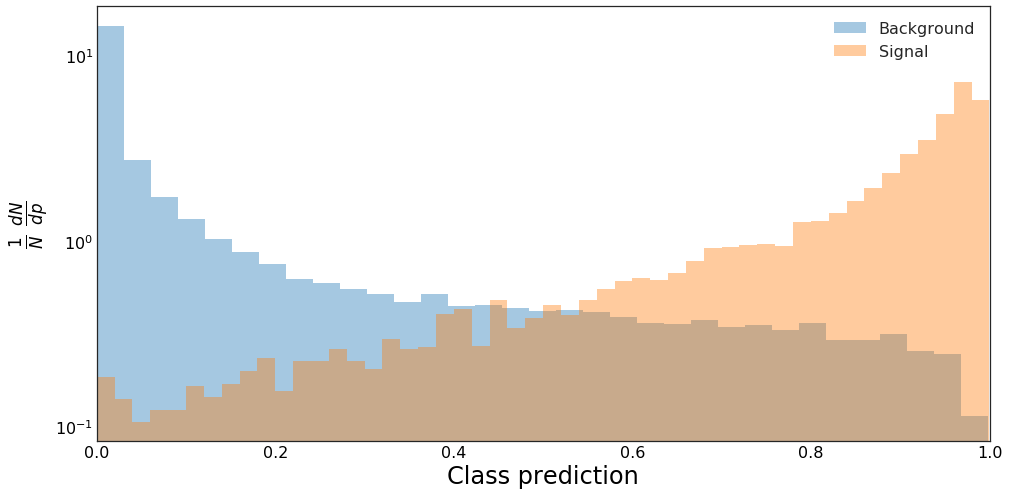

In [7]:
getClassPredPlot([valframe[bkgVal], valframe[sigVal]], weightName='gen_weight')

In [11]:
wFactor = 250000/50000

In [13]:
s = np.sum(valframe.loc[sigVal, 'gen_weight'])
b = np.sum(valframe.loc[bkgVal, 'gen_weight'])

In [14]:
tIIs = valframe['pred_class'].argsort()

In [15]:
amss = np.empty([len(tIIs)])

In [21]:
def amsScanQuick(inData, wFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = valframe['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if valframe.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

In [22]:
amsMax

3.870708332658265

In [23]:
threshold

0.9643758

In [72]:
valframe['ams'] = amsScan(valframe)[0]

[0.9643757939338684, 1.713268008464502]


In [73]:
bests = foldAMSScan(valframe, 10)

[0.9862657189369202, 2.163919932778619]
Fold 0, best AMS 2.16391993278 at cut of 0.986265718937. Total weights Signal:Bkg. 13.4734592438:8096.18652344


../Modules/Basics.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
../Modules/Basics.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))


[0.9709334373474121, 1.869430584275528]
Fold 1, best AMS 1.86943058428 at cut of 0.970933437347. Total weights Signal:Bkg. 13.5304965973:8235.09667969
[0.9682162404060364, 1.7659903204222163]
Fold 2, best AMS 1.76599032042 at cut of 0.968216240406. Total weights Signal:Bkg. 14.3802804947:8213.36523438
[0.9682491421699524, 2.4250152743983846]
Fold 3, best AMS 2.4250152744 at cut of 0.96824914217. Total weights Signal:Bkg. 13.8617801666:8192.44628906
[0.9758813977241516, 2.1841272897017334]
Fold 4, best AMS 2.1841272897 at cut of 0.975881397724. Total weights Signal:Bkg. 14.3048419952:8165.33154297
[0.8973569273948669, 1.6417366132719813]
Fold 5, best AMS 1.64173661327 at cut of 0.897356927395. Total weights Signal:Bkg. 13.9611206055:8101.59375
[0.9846431612968445, 1.8082062474868545]
Fold 6, best AMS 1.80820624749 at cut of 0.984643161297. Total weights Signal:Bkg. 14.3288793564:8268.97460938
[0.9805603623390198, 2.592851348247244]
Fold 7, best AMS 2.59285134825 at cut of 0.980560362339

In [87]:
print np.average([x[0] for x in bests])
print np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1.713268008464502-x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1/np.abs(1.713268008464502-x[1]) for x in bests])

0.9681299686431885
0.9662960151375813
0.9697595924146831
0.9781119217934711
0.9574692131271365


In [116]:
np.percentile(valframe.loc[:, 'pred_class'], 87)

0.956677633523941

In [74]:
batchEnsemblePredict(ensemble, weights, RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+")), ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00406625443805s per sample

Predicting batch 2 out of 10
Prediction took 0.00418002241742s per sample

Predicting batch 3 out of 10
Prediction took 0.00361573113095s per sample

Predicting batch 4 out of 10
Prediction took 0.00383700091189s per sample

Predicting batch 5 out of 10
Prediction took 0.00347507878217s per sample

Predicting batch 6 out of 10
Prediction took 0.00343026618091s per sample

Predicting batch 7 out of 10
Prediction took 0.0037712077791s per sample

Predicting batch 8 out of 10
Prediction took 0.00347717367519s per sample

Predicting batch 9 out of 10
Prediction took 0.00359226300066s per sample

Predicting batch 10 out of 10
Prediction took 0.00361840798205s per sample



In [112]:
saveTest(0.9462445050477981, 'Day_9_rr_85p')

../Data/Day_9_rr_85p_test.csv


In [113]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_9_rr_85p_test.csv -m"Day_9 Rot Ref 85p"

Successfully submitted to Higgs Boson Machine Learning Challenge